In [1]:
import functions, dataframe_cleaning
functions.import_all(globals())
df = dataframe_cleaning.clean_null_columns(df)

In [6]:
#now to explore value counts for all the columns to find placeholder values
#also try and find discrete data that should be represented as categorical data
df.dtypes.value_counts()

int64      11
float64     6
object      2
uint8       2
dtype: int64

In [9]:
int_df = df.select_dtypes(include="int64")
float_df = df.select_dtypes(include="float64")
obj_df = df.select_dtypes(include="object")
uint_df = df.select_dtypes(include="uint8")

In [11]:
#sanity_check
float_df.head()

,price,bathrooms,floors,view,lat,long
0,221900.0,1.00,1.0,0.0,47.5112,-122.257
1,538000.0,2.25,2.0,0.0,47.7210,-122.319
2,180000.0,1.00,1.0,0.0,47.7379,-122.233
3,604000.0,3.00,1.0,0.0,47.5208,-122.393
4,510000.0,2.00,1.0,0.0,47.6168,-122.045


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fbf88d0>,
      dtype=object)

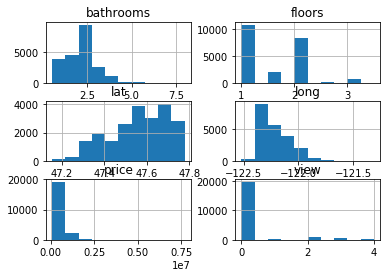

In [13]:
float_df.hist()

In [15]:
float_df.describe()
#there does not appear to be any placeholder values (except view which I want to revisit)

,price,bathrooms,floors,view,lat,long
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,2.115826,1.494096,0.233863,47.560093,-122.213982
std,3.673681e+05,0.768984,0.539683,0.764569,0.138552,0.140724
min,7.800000e+04,0.500000,1.000000,0.000000,47.155900,-122.519000
25%,3.220000e+05,1.750000,1.000000,0.000000,47.471100,-122.328000
50%,4.500000e+05,2.250000,1.500000,0.000000,47.571800,-122.231000
75%,6.450000e+05,2.500000,2.000000,0.000000,47.678000,-122.125000
max,7.700000e+06,8.000000,3.500000,4.000000,47.777600,-121.315000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20ab36a0>,
      dtype=object)

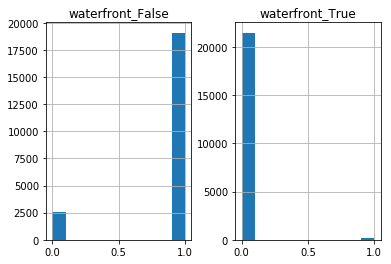

In [16]:
uint_df.hist()
#I actually created these values, - nothing to see here

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c21193d30>,
      dtype=object)

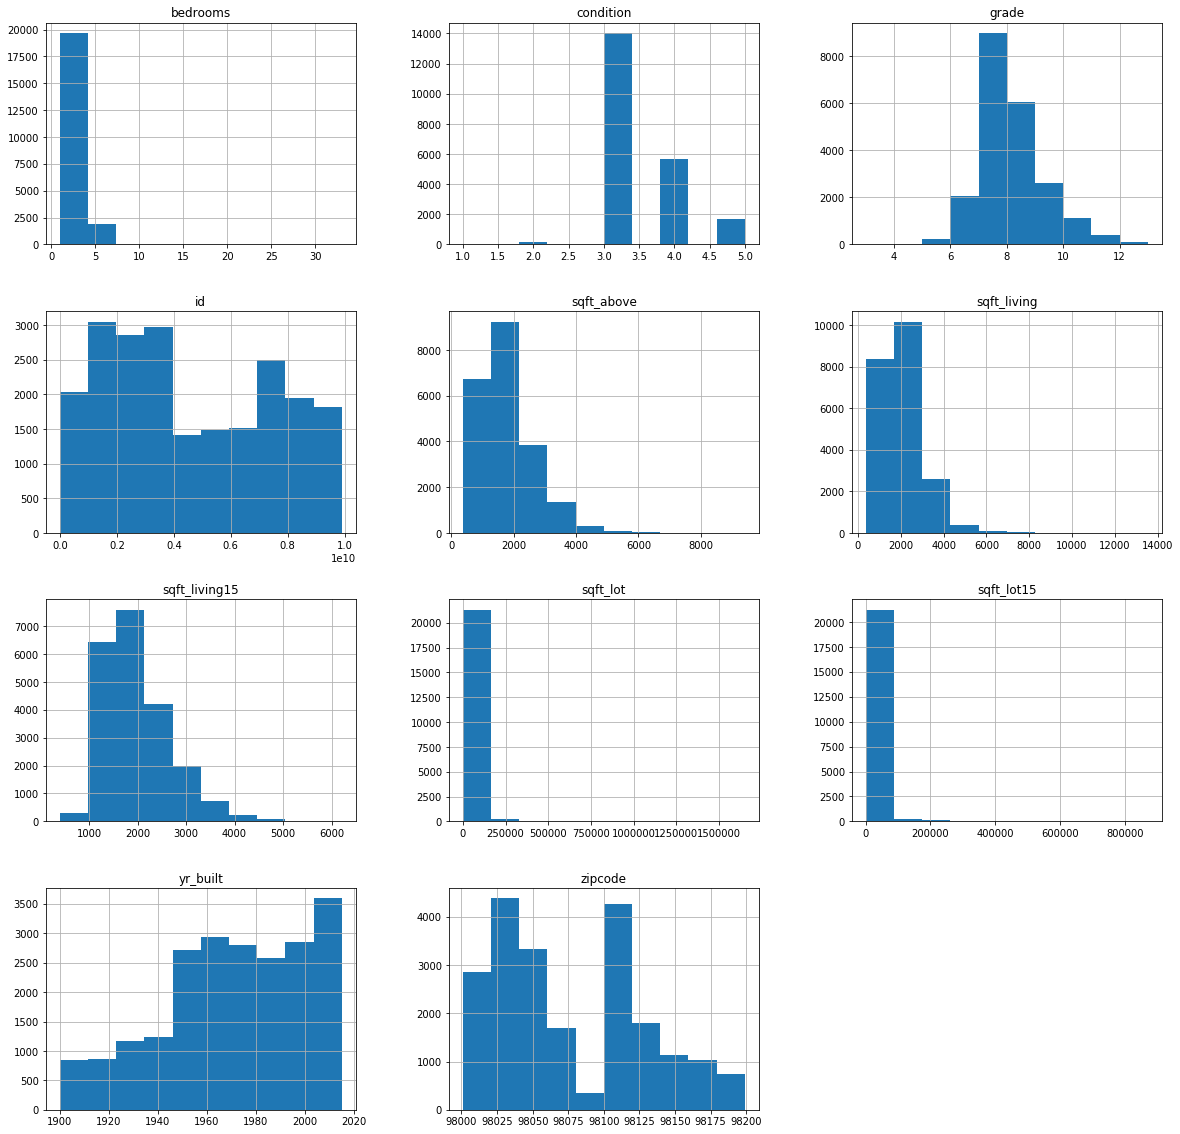

In [18]:
int_df.hist(figsize=(20,20))

In [19]:
int_df.describe()

,id,bedrooms,sqft_living,sqft_lot,condition,grade,sqft_above,yr_built,zipcode,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,3.373200,2080.321850,1.509941e+04,3.409825,7.657915,1788.596842,1970.999676,98077.951845,1986.620318,12758.283512
std,2.876736e+09,0.926299,918.106125,4.141264e+04,0.650546,1.173200,827.759761,29.375234,53.513072,685.230472,27274.441950
min,1.000102e+06,1.000000,370.000000,5.200000e+02,1.000000,3.000000,370.000000,1900.000000,98001.000000,399.000000,651.000000
25%,2.123049e+09,3.000000,1430.000000,5.040000e+03,3.000000,7.000000,1190.000000,1951.000000,98033.000000,1490.000000,5100.000000
50%,3.904930e+09,3.000000,1910.000000,7.618000e+03,3.000000,7.000000,1560.000000,1975.000000,98065.000000,1840.000000,7620.000000
75%,7.308900e+09,4.000000,2550.000000,1.068500e+04,4.000000,8.000000,2210.000000,1997.000000,98118.000000,2360.000000,10083.000000
max,9.900000e+09,33.000000,13540.000000,1.651359e+06,5.000000,13.000000,9410.000000,2015.000000,98199.000000,6210.000000,871200.000000


In [22]:
#again, nothing stands out as having placeholder values
#what about the object dataframe?
obj_df.head(1)

,date,sqft_basement
0,10/13/2014,0.0


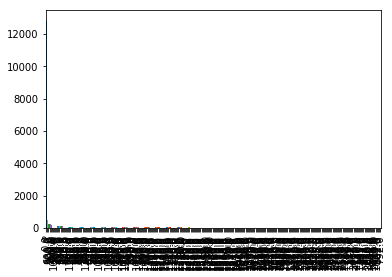

In [24]:
#something fishy is going on here...
obj_df.sqft_basement.value_counts().plot.bar()

In [25]:
obj_df.describe()

,date,sqft_basement
count,21597,21597
unique,372,304
top,6/23/2014,0.0
freq,142,12826


In [32]:
non_numeric_set = set()
def is_numeric(string):
    try:
        float(string)
        return True
    except Exception as e:
        non_numeric_set.add(string)
        return False
f"{len(obj_df)-sum(obj_df.sqft_basement.apply(is_numeric))}/{len(obj_df)}"

'454/21597'

In [31]:
#So there is one value preventing this column from casting to float
non_numeric_set

{'?'}

In [51]:
#Ideally I do not want to drop this column. How much noise will sticking the median in cause?
bsmt_df = df.loc[:,["price","sqft_basement"]]
dropped_bsmt = bsmt_df.drop(bsmt_df[bsmt_df.sqft_basement == "?"].index,axis=0)
dropped_bsmt.sqft_basement = dropped_bsmt.sqft_basement.astype(dtype="float64")

bsmt_median = dropped_bsmt.sqft_basement.median()
converted_bsmt = bsmt_df.copy()
converted_bsmt.sqft_basement = bsmt_df.sqft_basement.apply(
    lambda entry : bsmt_median if entry == "?" else entry)
converted_bsmt.sqft_basement = converted_bsmt.sqft_basement.astype("float64")


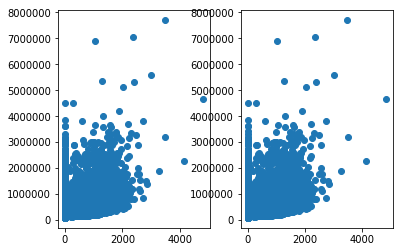

In [52]:
fig,axes = plt.subplots(ncols=2)

axes[0].scatter(x=dropped_bsmt.sqft_basement,y=dropped_bsmt.price)
axes[1].scatter(x=converted_bsmt.sqft_basement,y=converted_bsmt.price)


In [53]:
#uhoh, median and mean == 0
converted_bsmt.describe()

,price,sqft_basement
count,2.159700e+04,21597.000000
mean,5.402966e+05,285.716581
std,3.673681e+05,439.819830
min,7.800000e+04,0.000000
25%,3.220000e+05,0.000000
50%,4.500000e+05,0.000000
75%,6.450000e+05,550.000000
max,7.700000e+06,4820.000000


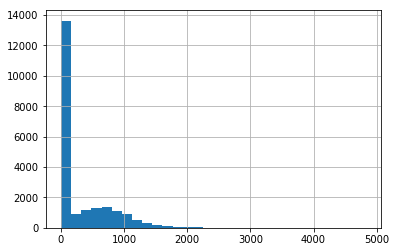

In [60]:
converted_bsmt.sqft_basement.hist(bins=30)

In [61]:
#Thats a lot of zeroes, but I am not conviced it represents missing data. Time to research if the location has a lot of properties without any basements
converted_bsmt.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
900.0       142
300.0       142
200.0       105
750.0       104
450.0       103
530.0       103
480.0       103
720.0        98
620.0        90
580.0        84
840.0        83
420.0        81
860.0        79
670.0        78
1100.0       78
780.0        76
550.0        76
650.0        75
240.0        74
680.0        73
380.0        73
850.0        72
360.0        72
          ...  
2600.0        1
2610.0        1
276.0         1
274.0         1
1245.0        1
143.0         1
266.0         1
862.0         1
2180.0        1
415.0         1
243.0         1
1135.0        1
1525.0        1
3000.0        1
172.0         1
225.0         1
518.0         1
935.0         1
1920.0        1
1930.0        1
1990.0        1
588.0         1
1548.0        1
2390.0        1
602.0         1
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Len

In [69]:
#could not find anything, but if it represents no basement you would think that it would have correlation with price
converted_bsmt["basement"] = converted_bsmt.sqft_basement.apply(
    lambda entry : 1 if entry > 0 else 0
)

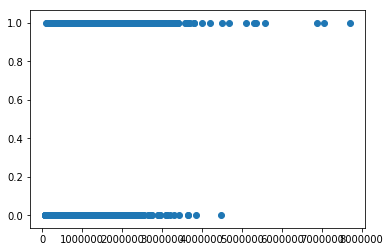

In [70]:
#plt.scatter(x=converted_bsmt.basement,y=converted_bsmt.price)
plt.scatter(y=converted_bsmt.basement,x=converted_bsmt.price)

In [71]:
features = sm.add_constant(converted_bsmt.basement)

sm.OLS(converted_bsmt.price,features).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     708.8
Date:                Sun, 05 May 2019   Prob (F-statistic):          1.12e-153
Time:                        21:24:55   Log-Likelihood:            -3.0704e+05
No. Observations:               21597   AIC:                         6.141e+05
Df Residuals:                   21595   BIC:                         6.141e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.885e+05   3136.895    155.718      0.000    4.82e+05    4.95e+05
basement    1.346e+05   5054.909     26.623      0.000    1.25e+05    1.44e+05
==============================================================================
Omnibus:                    19054.390   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1138734.509
Skew:                           4.002   Prob(JB):                         0.00
Kurtosis:                      37.661   Cond. No.                         2.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
#considering the p is low enough, I would say that it then indicates meaning rather than missing value
#final decision: set to median and convert col to float
#now on to date column
obj_df.date.dtype


dtype('O')

In [75]:
obj_df.date

0        10/13/2014
1         12/9/2014
2         2/25/2015
3         12/9/2014
4         2/18/2015
5         5/12/2014
6         6/27/2014
7         1/15/2015
8         4/15/2015
9         3/12/2015
10         4/3/2015
11        5/27/2014
12        5/28/2014
13        10/7/2014
14        3/12/2015
15        1/24/2015
16        7/31/2014
17        5/29/2014
18        12/5/2014
19        4/24/2015
20        5/14/2014
21        8/26/2014
22         7/3/2014
23        5/16/2014
24       11/20/2014
25        11/3/2014
26        6/26/2014
27        12/1/2014
28        6/24/2014
29         3/2/2015
            ...    
21567     6/10/2014
21568     12/2/2014
21569     8/28/2014
21570    10/15/2014
21571      3/5/2015
21572    11/13/2014
21573     9/10/2014
21574     5/14/2014
21575     10/2/2014
21576     4/16/2015
21577     3/17/2015
21578    10/17/2014
21579    10/31/2014
21580     8/13/2014
21581     4/21/2015
21582    10/13/2014
21583     9/15/2014
21584    10/15/2014
21585      4/7/2015


In [80]:
#Simple enough. It converts to datetime without any errors
pd.to_datetime(obj_df.date)

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
5       2014-05-12
6       2014-06-27
7       2015-01-15
8       2015-04-15
9       2015-03-12
10      2015-04-03
11      2014-05-27
12      2014-05-28
13      2014-10-07
14      2015-03-12
15      2015-01-24
16      2014-07-31
17      2014-05-29
18      2014-12-05
19      2015-04-24
20      2014-05-14
21      2014-08-26
22      2014-07-03
23      2014-05-16
24      2014-11-20
25      2014-11-03
26      2014-06-26
27      2014-12-01
28      2014-06-24
29      2015-03-02
           ...    
21567   2014-06-10
21568   2014-12-02
21569   2014-08-28
21570   2014-10-15
21571   2015-03-05
21572   2014-11-13
21573   2014-09-10
21574   2014-05-14
21575   2014-10-02
21576   2015-04-16
21577   2015-03-17
21578   2014-10-17
21579   2014-10-31
21580   2014-08-13
21581   2015-04-21
21582   2014-10-13
21583   2014-09-15
21584   2014-10-15
21585   2015-04-07
21586   2014-06-26
21587   2014-08-25
21588   2015